In [1]:
import jax.numpy as jnp
from jax import jit 
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import interpax
import pandas as pd

import h5py
from scipy.signal import find_peaks
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
from HelperAndMechanics import *
import progressbar

In [2]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,[] = read_config([],mode = 'chaos')

# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_var_l.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()
    
print(N)

15000


In [3]:
def sm_model(**kwargs_sys):

    #bounds for parameters
    nu_min, nu_max = kwargs_sys['nu_min'], kwargs_sys['nu_max']
    m_min, m_max = kwargs_sys['m_min'], kwargs_sys['m_max']
    l_g_min, l_g_max = kwargs_sys['l_g_min'], kwargs_sys['l_g_max']
    k_g_min, k_g_max = kwargs_sys['k_g_min'], kwargs_sys['k_g_max']
    k_a_min, k_a_max = kwargs_sys['k_a_min'], kwargs_sys['k_a_max']
    k_p_min, k_p_max = kwargs_sys['k_p_min'], kwargs_sys['k_p_max']
    eta_min, eta_max = kwargs_sys['eta_min'], kwargs_sys['eta_max']
    c_a_min, c_a_max = kwargs_sys['c_a_min'], kwargs_sys['c_a_max']
    
    # Interpolated params and coresponding time ,
    x_cm_arr = kwargs_sys['x_cm']
    x_j_arr = kwargs_sys['x_j']
    T_arr = kwargs_sys['T']
    t_interp = kwargs_sys['t_interp']

    def gen_y0():

        #takes initial conditions from kwargs(data)
        x1_0 = kwargs_sys['x1_0']
        x2_0 = kwargs_sys['x2_0']
        y1_0 = kwargs_sys['y1_0']
        y2_0 = kwargs_sys['y2_0']

        return {'x1':x1_0, 'x2':x2_0, 'y1':y1_0, 'y2':y2_0}

    def gen_params():
        # seed for reproducibility
        #np.random.seed(0)

        nu = nu_min + (nu_max - nu_min) * np.random.rand()
        m = m_min + (m_max - m_min) * np.random.rand()

        l_g = l_g_min + (l_g_max - l_g_min) * np.random.rand()
        # l_ax = l_ax_min + (l_ax_max - l_ax_min) * np.random.rand()

        c_a = c_a_min + (c_a_max - c_a_min) * np.random.rand()
        
        k_g = k_g_min + (k_g_max - k_g_min) * np.random.rand()
        k_a = k_a_min + (k_a_max - k_a_min) * np.random.rand()
        k_p = k_p_min + (k_p_max - k_p_min) * np.random.rand()
        
        eta0 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta1 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta2 = eta_min + (eta_max - eta_min) * np.random.rand()
        eta3 = eta_min + (eta_max - eta_min) * np.random.rand()

        return {'nu':nu,'m':m,'l_g':l_g,'k_g':k_g, 'k_a':k_a,'k_p':k_p, 'eta0':eta0 ,'eta1':eta1,'eta2':eta2,'eta3':eta3,'c_a':c_a}, {}, {}

        
    @jit
    def eom(xy, t, params, iparams, exparams):
        x = jnp.array([xy['x1'], xy['x2']])
        # get interpolated parameters at corresponding time
        x_cm = t_to_value_x(x_cm_arr,t_interp,t)
        x_j = t_to_value_x(x_j_arr,t_interp,t)
        l_ax =  ((jnp.array([params['eta0'],params['eta1'],params['eta2'],params['eta3']])-1/2)**2+1/2**2)**(1/2)
        l_a = t_to_value_l(l_ax.reshape(4,1)/(1 + params['c_a'] * T_arr),t_interp,t)

        #initialize total force
        f = total_force(x, x_j, x_cm,l_a ,t, params)

        #initialize eom
        dx1 = xy['y1']
        dx2 = xy['y2']
        dy1 = 1/params['m'] * (f[0] - params['nu'] * xy['y1'])
        dy2 = 1/params['m'] * (f[1] - params['nu'] * xy['y2'])

        return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

    @jit
    def loss(xy, params, iparams, exparams, targets):
        
        x1 = xy['x1']
        x2 = xy['x2']
        y1 = xy['y1']
        y2 = xy['y2']
        t_x1 = targets['x1']
        t_x2 = targets['x2']
        t_y1 = targets['y1']
        t_y2 = targets['y2']
        eta_diff = jnp.std(jnp.array([params['eta0'],params['eta1'],params['eta2'],params['eta3']]))
        return jnp.nanmean((x1-t_x1)**2 + (x2-t_x2)**2 +(y1 - t_y1)**2 + (y2 - t_y2)**2  + .001*eta_diff)

    return eom, loss, gen_params, gen_y0, {}

### Import Parameters

In [4]:
i,j = 50,60#5 + 5 * 10, 5 + 6 * 10

N,size,ls = read_config(["l_0","c_a","k_ij","k_j","k_a","m","c_damp","n_0","delta_t_m","it_m","pad"])
l_0, c_a0, k_g0, k_p0, k_a0, m0, nu0, eta0, delta_t_m, it_m, pad = ls
eta_arr = 1 - np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')
eta0,eta1,eta2,eta3= eta_arr[i-1,j-1],eta_arr[i-1,j],eta_arr[i,j],eta_arr[i,j-1]

real_params = {'l_g':l_0,'k_g':k_g0,'k_p':k_p0,'k_a':k_a0,'m':m0,'nu':nu0,'eta0':eta0,'eta1':eta1,'eta2':eta2,'eta3':eta3,'c_a': c_a0 }#,'dt':0}

delta_t = delta_t_m * it_m
t_evals = np.linspace(0,N*delta_t,N)
N_interp = int(it_m)*5

12515 14691


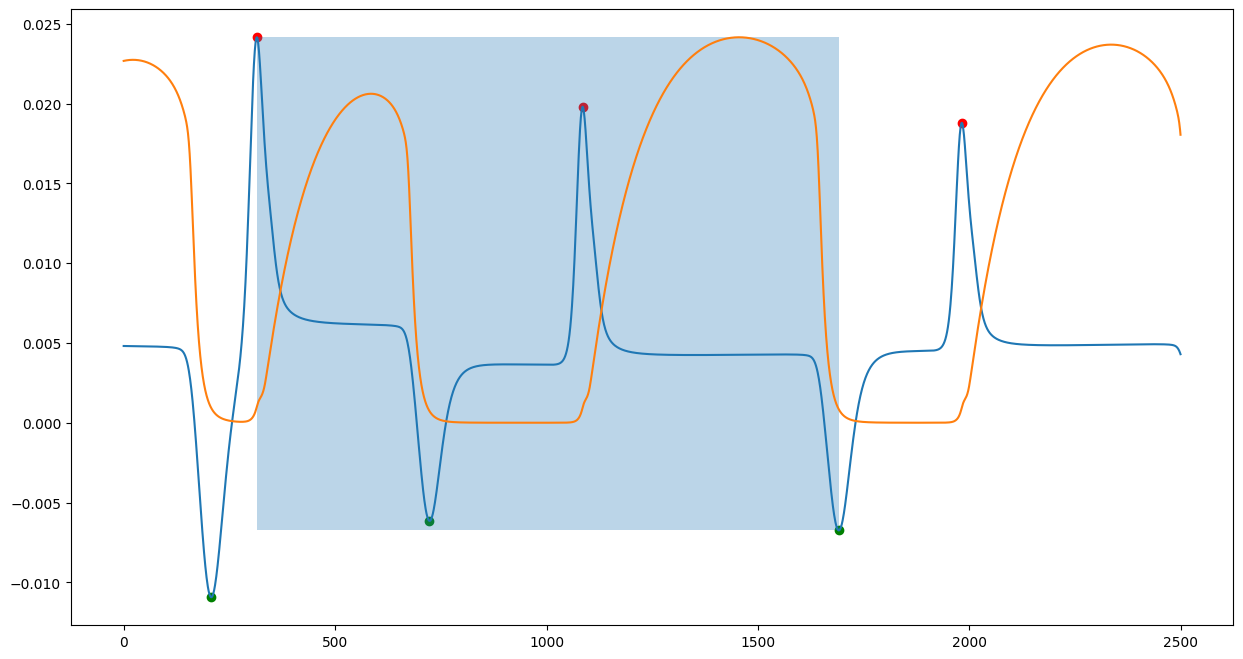

In [5]:
#T = u
t_start,t_stop = 0,T.shape[0]-3000
i,j = 50,60

dA_test = dA[t_stop+500:,i,j]
T_test = T[t_stop+500:,i,j]
maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx=0)


plt.figure(figsize=(15,8))
plt.plot(dA_test)
plt.scatter(maxima_temp0,dA_test[maxima_temp0],c='r')
plt.scatter(minima_temp0,dA_test[minima_temp0],c='g')
plt.fill_between([maxima_temp0[max_indx],minima_temp0[min_indx+1]],dA_test[minima_temp0[min_indx+1]],dA_test[maxima_temp0[max_indx]],alpha=.3)
plt.plot(T_test/np.max(T_test)*np.max(dA_test))

t_start_fit = t_stop + 500 + maxima_temp0[max_indx] - 300
t_stop_fit = t_stop + 500+ minima_temp0[min_indx+1] + 500

print(t_start_fit,t_stop_fit)

In [6]:
# Test for the plot
print(i,j)
start_indx = 0
T_arr = np.array([T[:,i-1,j-1],T[:,i-1,j],T[:,i,j],T[:,i,j-1]])
dA_arr = np.array([dA[:,i-1,j-1],dA[:,i-1,j],dA[:,i,j],dA[:,i,j-1]])

#np.save('../data/SpringMassModel/StandardPeaks/T_standard10.npy', T_arr[0,t_start:t_stop])
maxima, _ = find_peaks(dA_arr[0],prominence=.0007)
minima, _ = find_peaks(-dA_arr[0],prominence=.0007)

max_indx, min_indx = index_finder(maxima,minima,dA[:,i-1,j-1],start_indx)

t_start = maxima[max_indx]
t_stop = minima[min_indx]
print(t_start,t_stop)

50 60
207 733


Text(0.5, 0, 'timesteps')

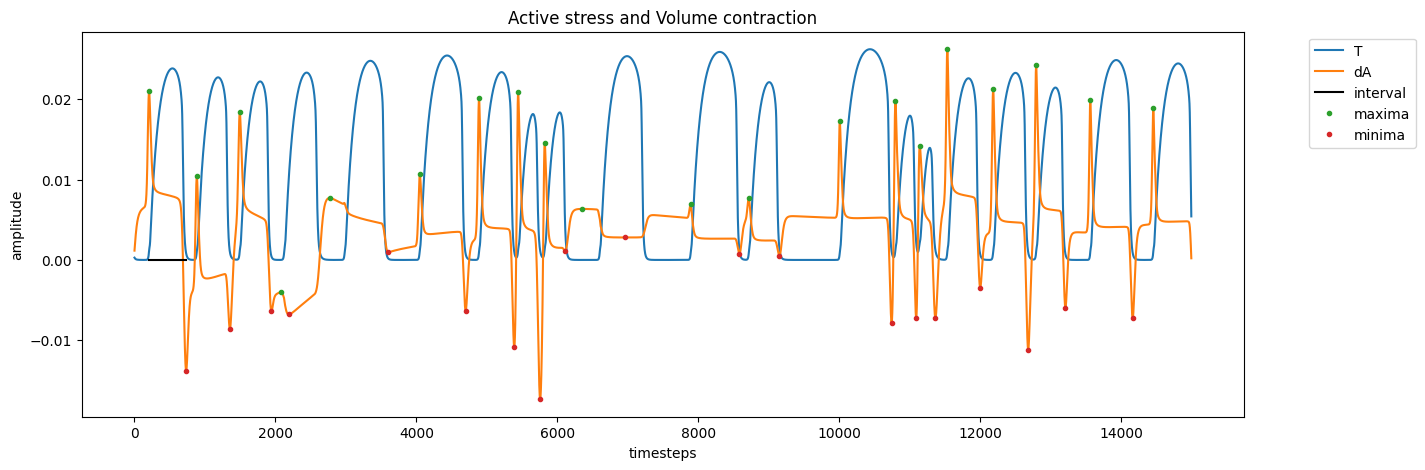

In [7]:
plt.figure(figsize=(15,5))
plt.plot(T_arr[0,:]/T_arr[0,:].max()*abs(dA_arr[0,:].max()),label="T")
plt.plot(dA_arr[0 ,:],label="dA")
plt.plot((t_start,t_stop),(0,0),color = 'black',label="interval")
plt.plot(maxima,dA[maxima,i-1,j-1], ".",label="maxima")
plt.plot(minima,dA[minima,i-1,j-1], ".",label="minima")
#x axis from 3000 to 6000
# plt.xlim(3000,6000)
# plt.ylim(-0.02,0.03)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Active stress and Volume contraction")
plt.ylabel('amplitude')
plt.xlabel('timesteps')
#plt.savefig("activestress_volcontraction_find_peak.png")

### Find indx for Peak


In [8]:
t_peak_start = np.array([])
t_peak_stop = np.array([])

for k in range(4):
    if k == 0:
        maxima_temp0, _ = find_peaks(dA_arr[k],prominence=.0007)#,height=.001
        minima_temp0, _ = find_peaks(-dA_arr[k],prominence=.0007)#,height=.001
        max_indx, min_indx = index_finder(maxima_temp0,minima_temp0,dA_arr[k],start_indx)

        t_start_temp, t_stop_temp = maxima_temp0[max_indx] , minima_temp0[min_indx]
        t_peak_start = np.append(t_peak_start,t_start_temp)
        t_peak_stop = np.append(t_peak_stop,t_stop_temp)
    else:
        maxima_temp, _ = find_peaks(dA_arr[k],prominence=.00001)
        minima_temp, _ = find_peaks(-dA_arr[k],prominence=.00001)
        t_start_temp, t_stop_temp = maxima_temp[np.abs(maxima_temp - maxima_temp0[max_indx]).argmin()] , minima_temp[np.abs(minima_temp - minima_temp0[min_indx]).argmin()]
        t_peak_start = np.append(t_peak_start,t_start_temp)
        t_peak_stop = np.append(t_peak_stop,t_stop_temp)

t_start = maxima_temp0[max_indx]
t_stop = minima_temp0[min_indx]

In [9]:
# plt.figure(figsize=(12,8))
# for i in range(9):
#     T_standard = np.load('../data/SpringMassModel/StandardPeaks/T_standard_new'+str(i+1)+'.npy')
#     T_test = create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop)
#     plt.plot(T_test[0,:],label= 'T_standard'+str(i+1))

# #T_test = create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop)
# plt.plot(T_arr[0,t_start:t_stop],linewidth=2.,label="T",color = 'black')
# #plt.plot(T_test[0,:],label="T_fit")
# plt.legend()
# np.save('../data/SpringMassModel/StandardPeaks/T_standard_new10.npy', T_arr[0,t_start:t_stop])


In [10]:
t_start = t_start_fit
t_stop = t_stop_fit

print('time interval='+str(t_start)+'-'+str(t_stop))

t_evals = np.linspace(0,N*delta_t,N)
t_evals = t_evals[t_start:t_stop] - t_evals[t_start]
#define standard peak
Delta_t_standard = t_stop - t_start

T_standard = np.load('../data/SpringMassModel/StandardPeaks/T_standard1.npy')
x_i,x_j,x_cm,l_a = shape_input_for_adoptode(x_temp[t_start:t_stop,:], x_cm_temp[t_start:t_stop,:],T[t_start:t_stop,:],i,j,1) # i and j specify the cell taken from the grid 
x_i_dot = np.append(np.diff(x_i,axis=0),np.diff(x_i,axis=0)[-1].reshape(1,2),axis=0)/(delta_t)
#T_model = create_T(T_standard, t_evals, t_start, delta_t, t_peak_start,t_peak_stop)
T_model = T_arr[:,t_start:t_stop]
T_rec = np.load('T_rec_test.npy')

start = 300
end = 1300#int(len(t_evals)-750)#*3/4)


x_i,x_j,x_cm = x_i[start:end,:],x_j[:,start:end,:],x_cm[:,start:end,:]
x_i_dot = x_i_dot[start:end,:]
t_evals = t_evals[start:end]
T_model = T_model[:,start:end]
T_rec = T_rec[:,start:end]
print(t_evals.shape)

#arrays interpolieren
t_interp, x_cm_interp = interpolate_x(x_cm,t_evals,N_interp)
t_interp, x_j_interp = interpolate_x(x_j,t_evals,N_interp)
t_interp, T_interp = interpolate_scalar(T_rec,t_evals,N_interp)

y0 = {"x1":x_i[0,0],'x2':x_i[0,1],'y1':(x_i[1,0]-x_i[0,0])/delta_t,'y2':(x_i[1,1]-x_i[0,1])/delta_t,'x_cm':x_cm[:,0,:],'x_j':x_j[:,0,:]}

time interval=12515-14691
(1000,)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


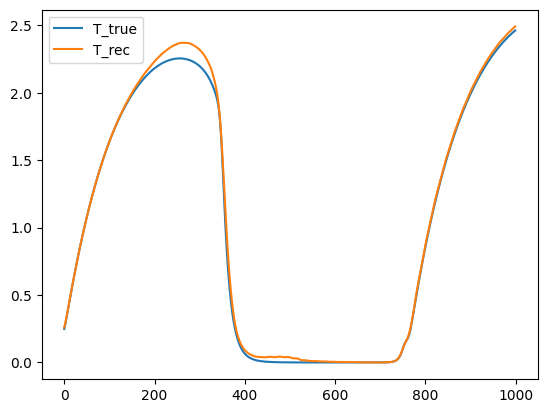

In [11]:
plt.plot(T_model[0,:],label="T_true")
plt.plot(T_rec[0,:],label = "T_rec")
plt.legend()

In [12]:
rel_err = 1        
kwargs_sys = { 
    'nu_min': nu0 - nu0 *rel_err,'nu_max': nu0 + nu0 *rel_err,
    'm_min': m0 - m0 *rel_err,'m_max' : m0 + m0 *rel_err,
    'l_g_min': l_0 - l_0 *rel_err,'l_g_max': l_0 + l_0 *rel_err,
    'k_g_min': k_g0 - k_g0 *rel_err,'k_g_max': k_g0 + k_g0 *rel_err,
    'k_p_min': k_p0 - k_p0 *rel_err,'k_p_max': k_p0 + k_p0 *rel_err,
    'k_a_min': k_a0 - k_a0 *rel_err,'k_a_max': k_a0 + k_a0 *rel_err,
    'c_a_min': c_a0 - c_a0 *rel_err,'c_a_max': c_a0 + c_a0 *rel_err,
    'eta_min': 0,'eta_max': 1,
    't_interp': t_interp,
    'N_interp': N_interp,
    'x_cm':x_cm_interp,
    'x_j':x_j_interp,
    'T':T_interp,
    'x1_0':x_i[0,0],
    'x2_0':x_i[0,1],
    'y1_0':x_i_dot[0,0],
    'y2_0':x_i_dot[0,1],
    'N_sys': 1    
}

#upper and lower bounds for parameters
tol = 1
real_params_low = {'l_g':l_0- l_0*tol,
                   'k_g':k_g0- k_g0*tol,'k_p':k_p0- k_p0*tol,
                   'k_a':k_a0- k_a0*tol,'m':m0- m0*tol,'nu':nu0- nu0*tol,'c_a': c_a0 - c_a0*tol ,'eta0':0,'eta1':0,'eta2':0,'eta3':0}
real_params_up = {'l_g':l_0+ l_0*tol,
                  'k_g':k_g0+ k_g0*tol,'k_p':k_p0+ k_p0*tol,
                  'k_a':k_a0+ k_a0*tol,'m':m0+ m0*tol,'nu':nu0+ nu0*tol,'c_a': c_a0 + c_a0*tol ,'eta':1,'eta1':1,'eta2':1,'eta3':1}

In [13]:
eta_diff = jnp.std(jnp.array([real_params['eta0'],real_params['eta1'],real_params['eta2'],real_params['eta3']]))
eta_diff*0.001

Array(3.896478e-06, dtype=float32)

In [14]:

targets = {"x1":x_i[:,0].reshape((1,len(x_i[:,0]))),'x2':x_i[:,1].reshape((1,len(x_i[:,0]))),'y1':x_i_dot[:,0].reshape((1,len(x_i_dot[:,0]))),'y2':x_i_dot[:,1].reshape((1,len(x_i_dot[:,1])))}
reset_every = 300
t_reset_idcs = tuple([
    reset_every * i
    for i in range(int(np.ceil((len(t_evals) - 1) / reset_every)))
])

kwargs_adoptODE = {'lr':.9e-2, 'epochs':1000,'N_backups':1,
                #    't_reset_idcs': t_reset_idcs,
                   'lower_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']-0*y0['y1'],'y2':y0['y2']-0*y0['y2'] },
                   'upper_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']+0*y0['y1'],'y2':y0['y2']+0*y0['y2'] },
                   'lower_b': real_params_low,
                   'upper_b': real_params_up}


dataset2 = dataset_adoptODE(sm_model,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE, 
                                true_params = real_params
                                )

In [15]:
params_final, losses, errors, params_history = train_adoptODE(dataset2,save_interval=100)

Epoch 000:  Loss: 5.2e-04,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 1.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 100:  Loss: 4.6e-04,  Params Err.: 1.3e+01, y0 error: nan, Params Norm: 1.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 200:  Loss: 5.5e-05,  Params Err.: 1.3e+01, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 300:  Loss: 2.8e-05,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 400:  Loss: 1.6e-05,  Params Err.: 1.5e+01, y0 error: nan, Params Norm: 2.0e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 500:  Loss: 1.1e-05,  Params Err.: 1.6e+01, y0 error: nan, Params Norm: 2.1e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 600:  Loss: 7.5e-06,  Params Err.: 1.7e+01, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 700:  Loss: 6.4e-06,  Params Err.: 1.7e+01, y0 error: na

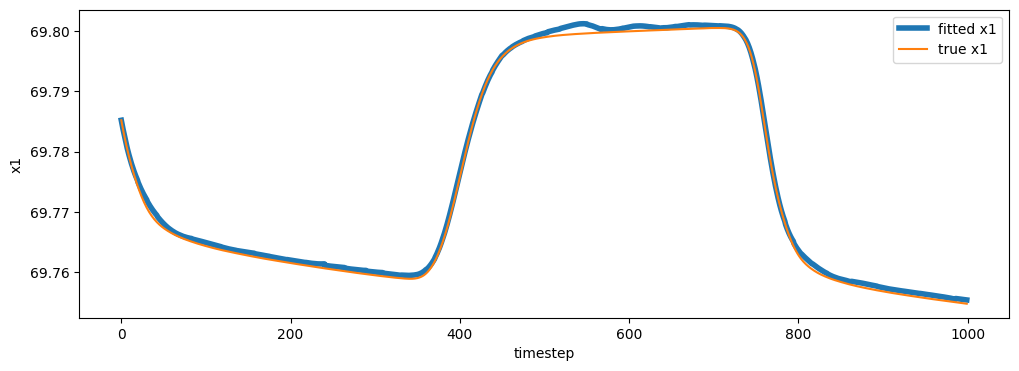

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(dataset2.ys_sol['x1'][0,0:],linewidth = 4,label= 'fitted x1')
plt.plot(dataset2.ys['x1'][0,0:],label= 'true x1')
# plt.plot(dataset2.ys_sol['x2'][0,0:],linewidth = 4,label= 'fitted x2')
# plt.plot(dataset2.ys['x2'][0,0:],label= 'true x2')
plt.ylabel('x1')
plt.xlabel('timestep')
plt.legend()
#plt.savefig("trajectory_overfittet2.png")

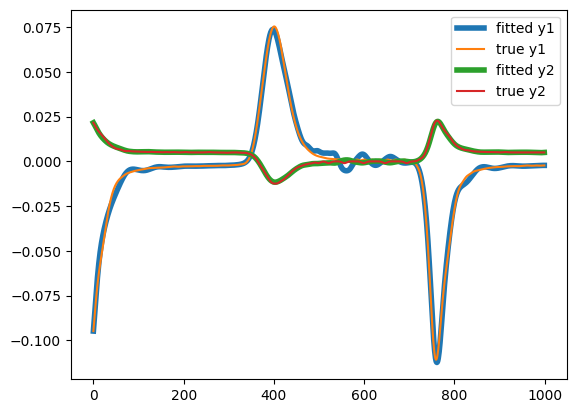

In [17]:
plt.plot(dataset2.ys_sol['y1'][0,0:],linewidth = 4,label= 'fitted y1')
plt.plot(dataset2.ys['y1'][0,0:],label= 'true y1')
plt.plot(dataset2.ys_sol['y2'][0,0:],linewidth = 4,label= 'fitted y2')
plt.plot(dataset2.ys['y2'][0,0:],label= 'true y2')
plt.legend()

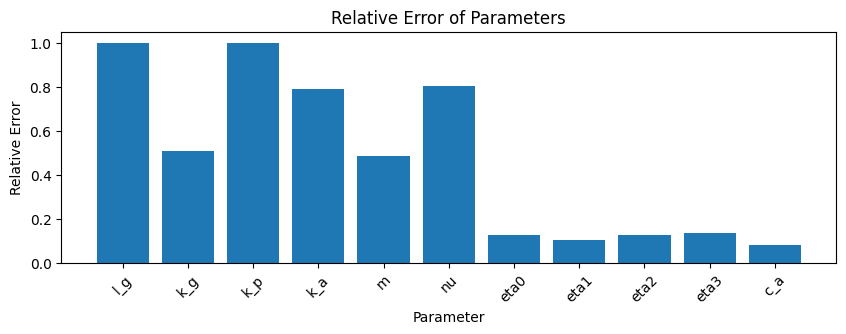

In [18]:
# Get the parameter names
param_names = list(real_params.keys())

# Calculate the relative error for each parameter
relative_errors = []
for param_name in param_names:
    real_value = real_params.get(param_name, np.nan)
    train_value = dataset2.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)

# Plot the relative errors
plt.figure(figsize=(10, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [19]:
print(dataset2.params_train['eta0'],real_params['eta0'],dataset2.params_train['eta1'],real_params['eta1'],dataset2.params_train['eta2'],real_params['eta2'],dataset2.params_train['eta3'],real_params['eta3'])

0.41698116 0.37073517 0.4158268 0.37786818 0.42114872 0.37473482 0.41724515 0.36759865
